In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loader import *
from models import *
from utils import *
from plotting import *

In [3]:
# load_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\Transfer rep 5 and 6\\results\\ver1\\models\\seq_len1_b7.keras'
# model = keras.models.load_model(load_path_model, custom_objects={'softmax_categorical':softmax_categorical})

In [4]:
load_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\transfer\\models\\one_frame_all_sizes.keras'
model = keras.models.load_model(load_path_model, custom_objects={'softmax_categorical':softmax_categorical})

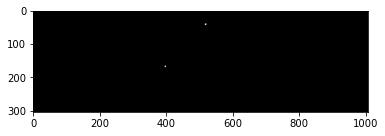

In [5]:
folder_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\From erik\\Transfer'
col_delete_list=[0, 140, 1150, 1280]
row_delete_list=[0, 200, 350, 720, 880, 1024]
im_stack = get_image_stack(
            outputs=[0], 
            folder_path=folder_path, 
            frame_im0=70, 
            im_size_width=1008, 
            im_size_height=304,
            im_resize_width=1280, 
            im_resize_height=1024,
            function_img=[RemoveRunningMean, crop_and_append_image, Normalize_image],
            row_delete_list=row_delete_list, 
            col_delete_list=col_delete_list,
            path_folder=folder_path,
            tot_no_of_frames=15, 
            im_height=1024,
            im_width=1280)

# plot_image_stack(im_stack)
# plot_prediction(model=model, im_stack=im_stack)
plt.imshow(model.predict(im_stack)[0,:,:,1]>0.9, cmap='gray')
plt.show()

In [6]:
positions = extract_positions(
    no_of_frames=100, 
    outputs=[0], 
    folder_path=folder_path, 
    frame_im0=0, 
    model=model, 
    layer=1, 
    value_threshold=0.6,
    im_size_width=1008, 
    im_size_height=304,
    im_resize_width=1280, 
    im_resize_height=1024,
    function_img=[RemoveRunningMean, crop_and_append_image, Normalize_image],
    row_delete_list=row_delete_list, 
    col_delete_list=col_delete_list,
    path_folder=folder_path,
    tot_no_of_frames=12, 
    im_height=1024,
    im_width=1280)


In [7]:
new_positions = fix_positions_from_cropping(
    positions, col_delete_list=col_delete_list, row_delete_list=row_delete_list)

In [8]:
list_of_plankton = assign_positions_to_planktons(new_positions, max_dist=90, threshold = 10, extrapolate=False)
list_of_plankton = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
list_of_plankton = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=5)

plankton_track, plankton_dont_track = split_plankton(percentage_threshold=0.0, list_of_plankton=list_of_plankton)

In [114]:
# plot_and_save_track(no_of_frames=100,
#                     plankton_track=plankton_track,
#                     plankton_dont_track=plankton_dont_track,
#                     folder_path=folder_path,
#                     frame_im0=0,
#                     save_images=1,
#                     show_plankton_track = True,
#                     show_plankton_dont_track = 0,
#                     show_numbers_track = 0,
#                     show_numbers_dont_track = 0,
#                     show_numbers_specific_plankton = False,
#                     show_specific_plankton = False,
#                     specific_plankton = None,
#                     color_plankton_track = 'b',
#                     color_plankton_dont_track = 'r',
#                     color_specific_plankton = 'w',
#                     save_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\transfer\\track1',
#                     frame_name = 'track',
#                     file_type = '.jpg')

In [115]:
# Make_video(frame_im0=0,
#            folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\transfer\\track1', 
#            save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\transfer\\Test_video1.avi', 
#            fps=7, 
#            no_of_frames=100)

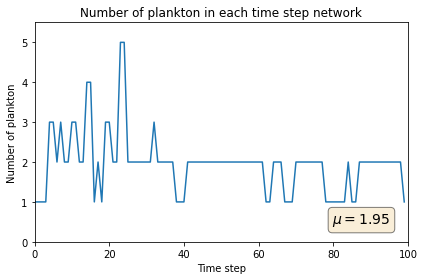

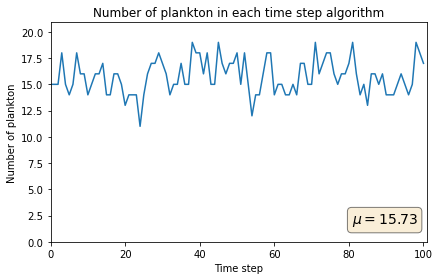

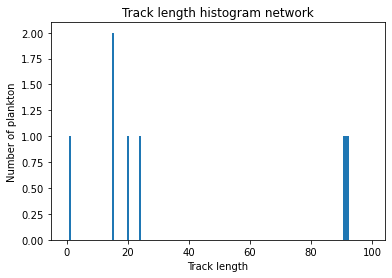

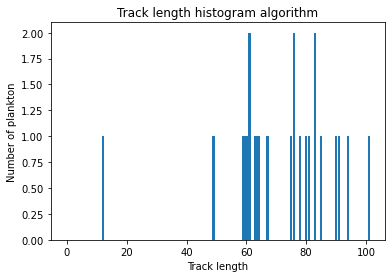

In [9]:
import xml.etree.ElementTree as ET

def plot_statistics(found_plankton_at_timestep, title):
    cropped_finds = found_plankton_at_timestep[np.nonzero(found_plankton_at_timestep)[0]]

    ax = plt.figure()
    plt.plot(range(len(cropped_finds)), cropped_finds)
    plt.xlabel('Time step')
    plt.ylabel('Number of plankton')
    plt.title(title)
    plt.tight_layout()
    mu = np.mean(cropped_finds)
    
    plt.axis([0, len(cropped_finds), 0, max(cropped_finds)*1.1])
    
    textstr = r'$\mu=%.2f$' % (mu, )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.8, 0.25, textstr, fontsize=14,
            verticalalignment='top', bbox=props)
    
def get_found_plankton_at_timestep(plankton_track):
    no_timesteps = len(plankton_track[list(plankton_track.keys())[0]].positions)
    found_plankton_at_timestep = np.zeros(no_timesteps)

    for plankton in plankton_track:
        plankton = np.array(plankton_track[plankton].positions[:,0], dtype=float)
        where_list = np.where(np.isfinite(plankton))
        for i in where_list[0]:
            found_plankton_at_timestep[i] += 1
    return found_plankton_at_timestep

def get_found_plankton_from_xml(path, no_timesteps, var_str):
    tree = ET.parse(path)
    root = tree.getroot()


    found_plankton_at_timestep = np.zeros(no_timesteps)

    for particle in root.iter():
        my_dict = particle.attrib
        if var_str in my_dict:
            found_plankton_at_timestep[int(float(my_dict[var_str]))] += 1
    return found_plankton_at_timestep


def plot_bars(track_durations, title):
    plt.figure()
    plt.bar(range(len(track_durations)), track_durations)
    
    plt.xlabel('Track length')
    plt.ylabel('Number of plankton')
    plt.title(title)



def get_track_durations(plankton_track):
    no_of_timesteps = len(plankton_track[list(plankton_track.keys())[0]].positions)
    track_durations = np.zeros(no_of_timesteps)
    for plankton in plankton_track:
        plankton = np.array(plankton_track[plankton].positions[:,0], dtype=float)
        where_list = np.where(np.isfinite(plankton))
        track_start = np.min(where_list)
        track_end = np.max(where_list)

        track_durations[track_end-track_start] += 1
    return track_durations


found_plankton_at_timestep_net = get_found_plankton_at_timestep(plankton_track)     
plot_statistics(found_plankton_at_timestep_net, 'Number of plankton in each time step network')


pathbot = "E:\\Documents\\Master\\exjobb\\software\\Tracking\\Transfer_cropped_bottom_arena_Tracks.xml"
pathtop = "E:\\Documents\\Master\\exjobb\\software\\Tracking\\Transfer_cropped_top_arena_Tracks.xml"
no_timesteps = 102
found_plankton_at_timestep_bot = get_found_plankton_from_xml(pathbot, no_timesteps, 't')
found_plankton_at_timestep_top = get_found_plankton_from_xml(pathtop, no_timesteps, 't')
found_plankton_at_timestep_alg = found_plankton_at_timestep_bot + found_plankton_at_timestep_top
plot_statistics(found_plankton_at_timestep_alg, 'Number of plankton in each time step algorithm')


track_durations_net = get_track_durations(plankton_track)
plot_bars(track_durations_net, 'Track length histogram network')


track_durations_top = get_found_plankton_from_xml(pathtop, no_timesteps, 'nSpots')
track_durations_bot = get_found_plankton_from_xml(pathbot, no_timesteps, 'nSpots')
track_durations_alg = track_durations_top + track_durations_bot
plot_bars(track_durations_alg, 'Track length histogram algorithm')

Text(0.77, 0.55, '$\\mu=15.58$\n$\\mu=1.95$')

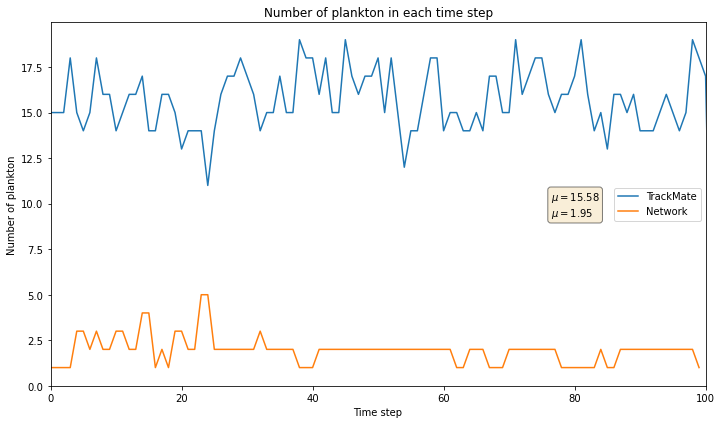

In [10]:
ax = plt.figure(figsize=(10,6))

plt.plot(found_plankton_at_timestep_alg)
mualg = np.mean(found_plankton_at_timestep_alg)

plt.plot(found_plankton_at_timestep_net)
munet= np.mean(found_plankton_at_timestep_net)


plt.legend(['TrackMate', 'Network'], loc='right')

plt.xlabel('Time step')
plt.ylabel('Number of plankton')
plt.title('Number of plankton in each time step')
plt.tight_layout()


plt.xlim(left=0)
plt.xlim(right=100)

plt.ylim(bottom=0)

textstr = '\n'.join((
    r'$\mu=%.2f$' % (mualg, ),
    r'$\mu=%.2f$' % (munet, )
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.77, 0.55, textstr, fontsize=10,
        verticalalignment='top', bbox=props)